# Assignment 3 | Problem 2
A new dataset is created, consisting of 15,000 28x28 pixel images of shapes including circles, triangles, and squares.

A seed of `42` is set for reproducibility to keep a constant result.

## Generate dataset

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def generate_shapes_dataset(num_samples=15000, img_size=28):
    """
    Generates a dataset of 28x28 images with circles, triangles, and rectangles.
    Returns: (images, labels) where labels are 0=circle, 1=triangle, 2=rectangle.
    """
    images = np.zeros((num_samples, img_size, img_size, 1), dtype=np.float32)
    labels = np.zeros(num_samples, dtype=np.int32)

    for i in range(num_samples):
        # Create a blank image
        img = np.zeros((img_size, img_size), dtype=np.uint8)

        # Randomly choose a shape
        shape_class = np.random.randint(0, 3)
        labels[i] = shape_class

        # Define shape color (white)
        shape_color = 255  # White for 8-bit grayscale

        if shape_class == 0:  # Circle
            center = (random.randint(10, img_size-10), random.randint(10, img_size-10))
            radius = random.randint(5, 10)
            cv2.circle(img, center, radius, shape_color, -1)  # -1 for filled circle

        elif shape_class == 1:  # Triangle
            # Generate random vertices for a triangle
            pt1 = (random.randint(5, img_size-5), random.randint(5, img_size-5))
            pt2 = (random.randint(5, img_size-5), random.randint(5, img_size-5))
            pt3 = (random.randint(5, img_size-5), random.randint(5, img_size-5))

            pts = np.array([pt1, pt2, pt3], np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.fillPoly(img, [pts], shape_color)

        else:  # shape_class == 2, Rectangle
            side = random.randint(10, 15)
            top_left_x = random.randint(5, img_size-side-5)
            top_left_y = random.randint(5, img_size-side-5)
            cv2.rectangle(img, (top_left_x, top_left_y),
                          (top_left_x + side, top_left_y + side),
                          shape_color, -1)

        # Normalise to [0, 1] and add channel dimension
        images[i, :, :, 0] = img.astype(np.float32) / 255.0

    return images, labels

Generating dataset...
Dataset shape: (15000, 28, 28, 1)


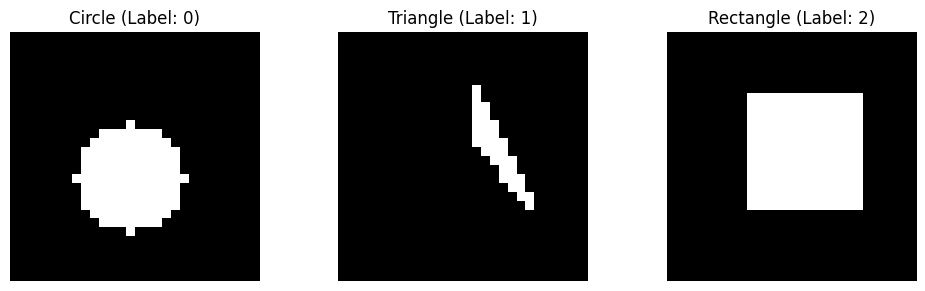

In [2]:
# Call dataset generation
print("Generating dataset...")
X, y = generate_shapes_dataset(15000)
print(f"Dataset shape: {X.shape}")


# Display one sample of each shape
shape_names = ['Circle', 'Triangle', 'Rectangle']
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for i, shape_name in enumerate(shape_names):
    # Find the first occurrence of this shape in the dataset
    idx = np.where(y == i)[0][0]

    # Display the image
    axes[i].imshow(X[idx].squeeze(), cmap='gray')
    axes[i].set_title(f'{shape_name} (Label: {i})')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (10500, 28, 28, 1), Val: (2250, 28, 28, 1), Test: (2250, 28, 28, 1)


## Build VAE Model

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):  # Override
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
# Define encoder
latent_dim = 8 # Small latent dimension for a simple task

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [6]:
# Define decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [7]:
## Define VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        # Define the forward pass
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x, _ = data  # Unpack the data tuple
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x, _ = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

vae = VAE(encoder, decoder)

## Train VAE

In [8]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
history = vae.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_val, X_val))

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - kl_loss: 5.9375 - loss: 292.8884 - reconstruction_loss: 286.9508 - val_kl_loss: 9.5352 - val_reconstruction_loss: 218.1418 - val_total_loss: 227.6769
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 7.8850 - loss: 210.7290 - reconstruction_loss: 202.8441 - val_kl_loss: 9.6802 - val_reconstruction_loss: 190.9602 - val_total_loss: 200.6404
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 11.2852 - loss: 180.0161 - reconstruction_loss: 168.7309 - val_kl_loss: 12.9020 - val_reconstruction_loss: 151.4031 - val_total_loss: 164.3052
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 12.1689 - loss: 146.9418 - reconstruction_loss: 134.7728 - val_kl_loss: 12.3513 - val_reconstruction_loss: 114.6739 - val_total_loss: 127.0252
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 14.0120 - loss: 93.0434 - reconstruction_loss: 79.0314 - val_kl_loss: 15.6569 - val_reconstruction_loss: 56.6536 - val_tot

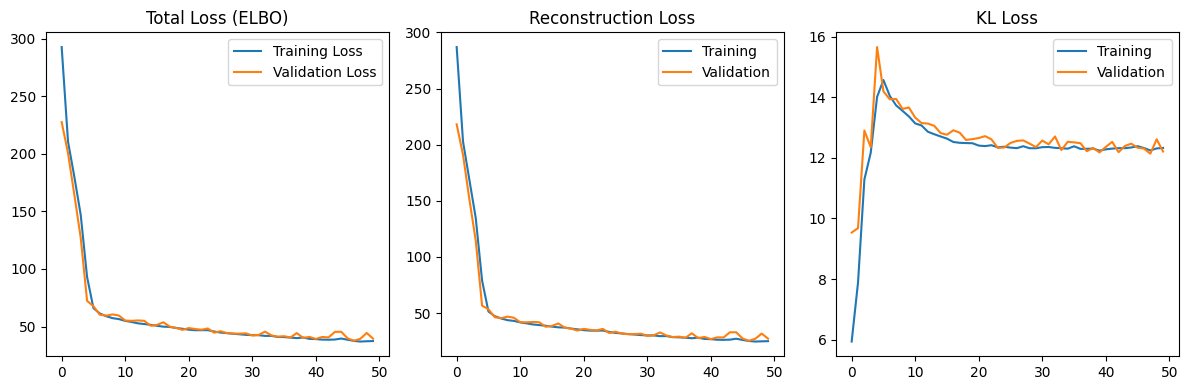

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_total_loss'], label='Validation Loss')
plt.title('Total Loss (ELBO)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='Training')
plt.plot(history.history['val_reconstruction_loss'], label='Validation')
plt.title('Reconstruction Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'], label='Training')
plt.plot(history.history['val_kl_loss'], label='Validation')
plt.title('KL Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Generate New Data and Evaluate

In [10]:
def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.5
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi] + [0]*(latent_dim-2)])  # Only vary first 2 dims
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].squeeze()
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.title("VAE Latent Space Sampling (First 2 Dimensions)")
    plt.show()

Generating samples from learned latent space:


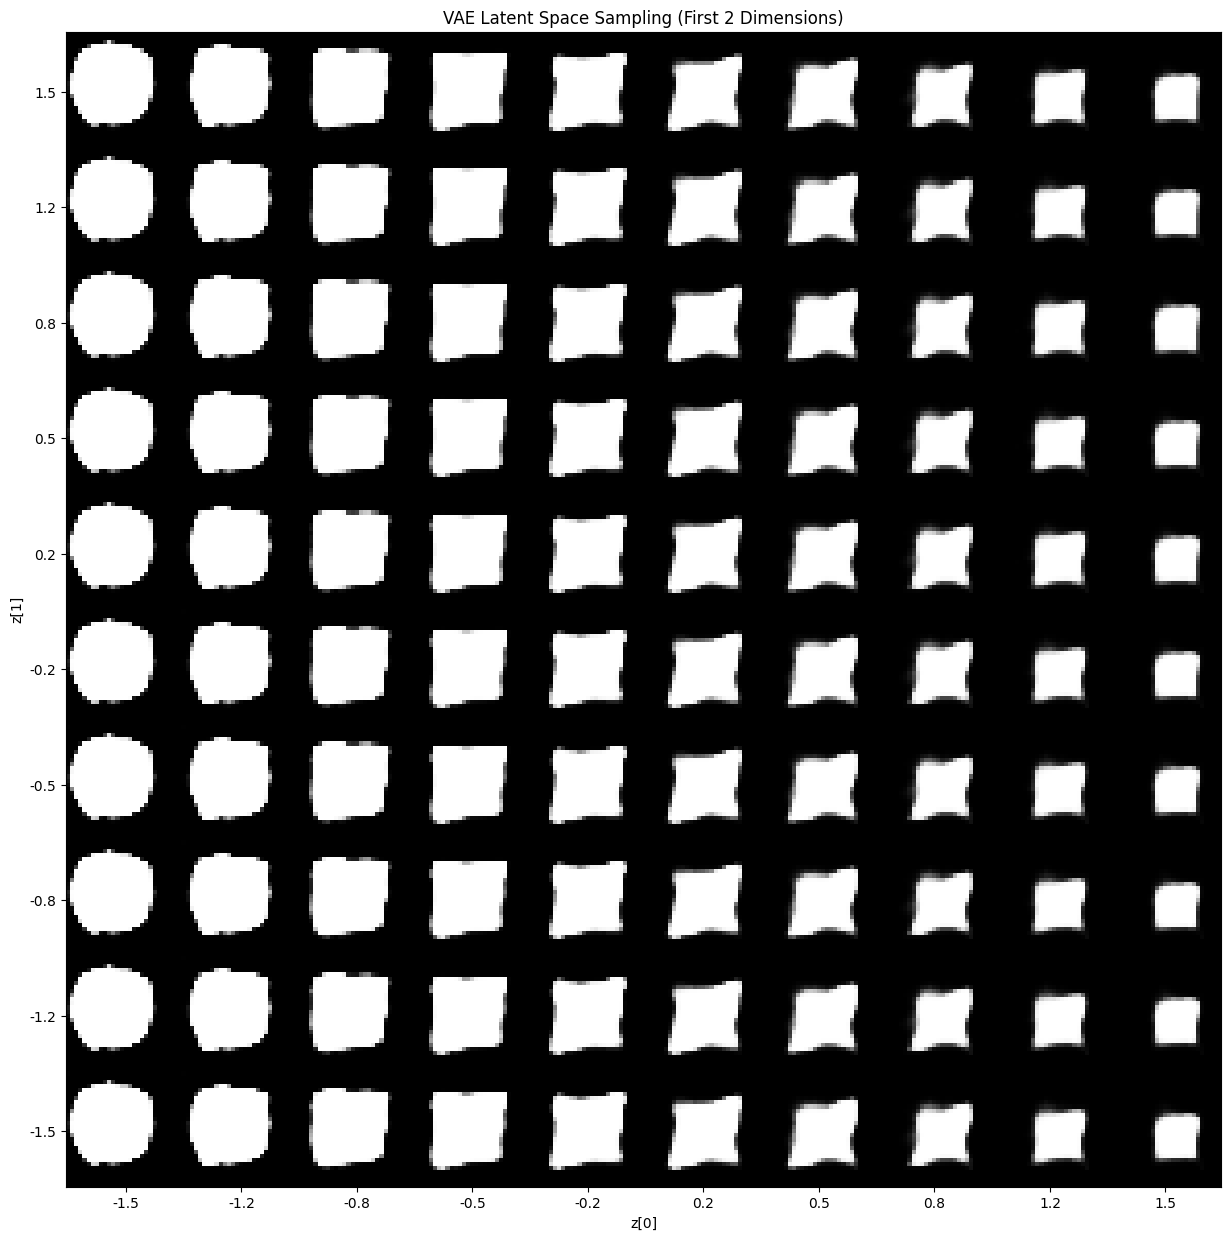

In [11]:
print("Generating samples from learned latent space:")
plot_latent_space(vae)

In [12]:
# Calculate reconstruction BCE on test set
test_reconstructions = vae.decoder.predict(vae.encoder.predict(X_test)[2], verbose=0)  # Get z by indexing [2]
test_bce = tf.reduce_mean(keras.losses.binary_crossentropy(X_test, test_reconstructions)).numpy()
print(f"Test Set Binary Cross-Entropy: {test_bce:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Set Binary Cross-Entropy: 0.0346


## Modified VAE

In [18]:
# Create new model that reuses the encoder/decoder but has a different loss
class ModifiedVAE(keras.Model):
    def __init__(self, encoder, decoder, kl_weight=10.0, noise_stddev=0.5, **kwargs):
        super(ModifiedVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight
        self.noise_stddev = noise_stddev
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        # Define the forward pass
        z_mean, z_log_var, z = self.encoder(inputs)
        # Add noise during forward pass (for training)
        z_noisy = z + tf.random.normal(tf.shape(z), stddev=self.noise_stddev)
        reconstruction = self.decoder(z_noisy)
        return reconstruction

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        x, _ = data  # Unpack the data tuple
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            # Add fixed noise to the latent representation
            z_noisy = z + tf.random.normal(tf.shape(z), stddev=self.noise_stddev)
            reconstruction = self.decoder(z_noisy) # Decode from noisy z

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )
            # KL Loss to force distribution to be N(0, I)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            # Weight the KL loss heavily to enforce the prior
            total_loss = reconstruction_loss + self.kl_weight * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, _ = data
        z_mean, z_log_var, z = self.encoder(x)
        # For testing, don't add noise to get a deterministic reconstruction
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = reconstruction_loss + self.kl_weight * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "val_loss": total_loss,
            "val_reconstruction_loss": reconstruction_loss,
            "val_kl_loss": kl_loss
        }

In [19]:
# Create and train the modified model
modified_vae = ModifiedVAE(encoder, decoder, kl_weight=10.0, noise_stddev=0.5)
modified_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
print("Training Modified VAE (Basic AE with strong KL loss and latent noise)...")
history_mod = modified_vae.fit(X_train, X_train, epochs=30, batch_size=128, validation_data=(X_val, X_val))  # Shorter training

Training Modified VAE (Basic AE with strong KL loss and latent noise)...
Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - kl_loss: 6.8498 - reconstruction_loss: 155.8409 - total_loss: 224.3391 - val_val_kl_loss: 5.8074 - val_val_loss: 145.1164 - val_val_reconstruction_loss: 87.0420
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - kl_loss: 5.5216 - reconstruction_loss: 112.6592 - total_loss: 167.8750 - val_val_kl_loss: 5.1950 - val_val_loss: 141.6653 - val_val_reconstruction_loss: 89.7158
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - kl_loss: 5.1854 - reconstruction_loss: 107.2945 - total_loss: 159.1483 - val_val_kl_loss: 5.1272 - val_val_loss: 136.6838 - val_val_reconstruction_loss: 85.4118
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - kl_loss: 5.0331 - reconstruction_loss: 104.7833 - total_loss: 155.1139 - val_val_kl_loss: 5.0072 - val_val_loss: 131.7319 - val_val_reconstruction_loss: 81.6600
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - kl_loss: 4.9430 - 

## Estimate Information for Modified VAE

In [20]:
# Get latent representations (z) for the test set from the encoder
z_mean, z_log_var, z = modified_vae.encoder.predict(X_test, verbose=0)
z_variance = np.var(z, axis=0) # Variance of each latent dimension across the dataset (signal variance)
avg_z_variance = np.mean(z_variance) # Average signal variance

# The noise we added has a fixed variance: noise_stddev^2
noise_variance = modified_vae.noise_stddev ** 2

# Calculate SNR and Information for each dimension (using Equation 2 from lecture notes)
SNR = z_variance / noise_variance
# Information I(Y;Z) = 1/2 * log2(1 + SNR) bits (approx for Gaussian, based on eq (2))
information_bits_per_dim = 0.5 * np.log2(1 + SNR)
total_information_bits = np.sum(information_bits_per_dim)

In [21]:
print("\n--- Information Analysis for Modified VAE ---")
print(f"Average Signal Variance (across latent dims): {avg_z_variance:.4f}")
print(f"Fixed Noise Variance: {noise_variance:.4f}")
print(f"Average SNR: {np.mean(SNR):.4f}")
print(f"Information per dimension (bits): {information_bits_per_dim}")
print(f"Total information passing through latent layer: {total_information_bits:.2f} bits")


--- Information Analysis for Modified VAE ---
Average Signal Variance (across latent dims): 1.4697
Fixed Noise Variance: 0.2500
Average SNR: 5.8787
Information per dimension (bits): [1.5543957 1.1844578 1.5485808 1.5830791 1.1435804 1.5429869 1.20066
 1.1679566]
Total information passing through latent layer: 10.93 bits


## Compare Standard VAE vs Modified VAE


--- Performance Comparison ---
Standard VAE Test BCE: 0.0346
Modified VAE Test BCE: 0.0968
Standard VAE Latent Space:


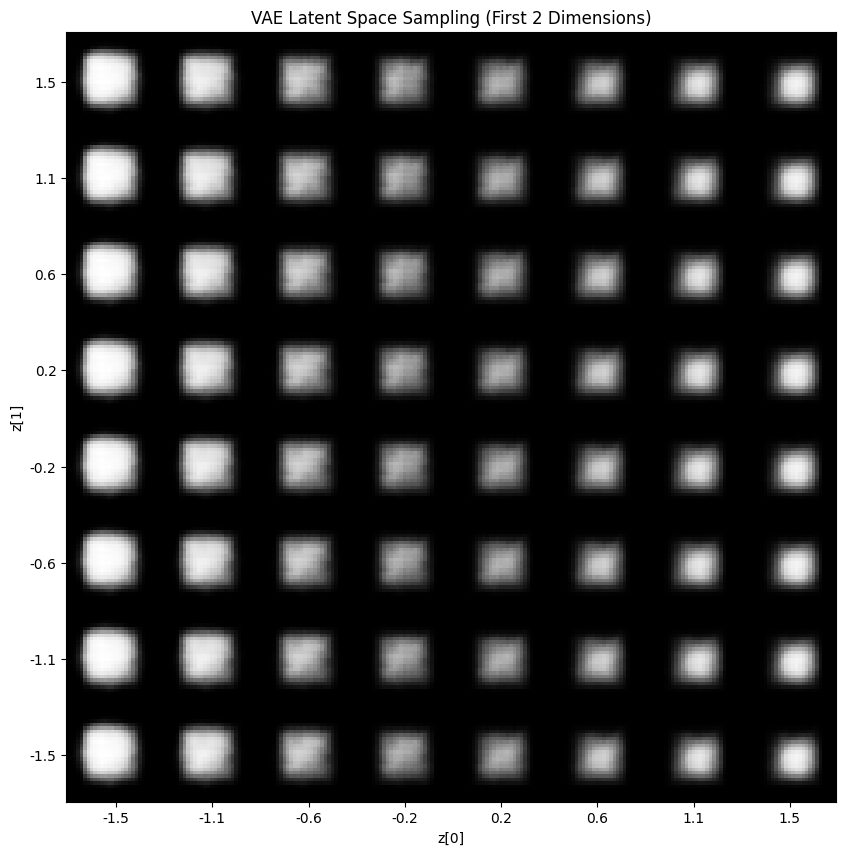

Modified VAE Latent Space (First 2 Dims):


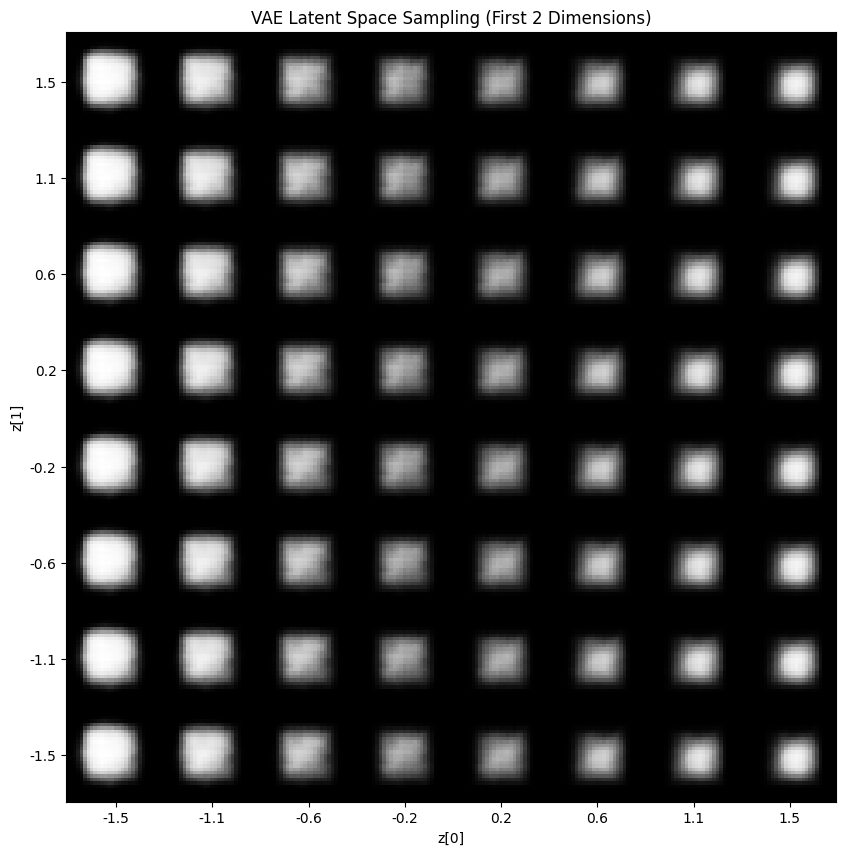

In [22]:
# Compare Test Reconstruction Error
test_reconstructions_mod = modified_vae.decoder.predict(z, verbose=0) # Use the original z, not z_noisy, for fair comparison
test_bce_mod = tf.reduce_mean(keras.losses.binary_crossentropy(X_test, test_reconstructions_mod)).numpy()

print("\n--- Performance Comparison ---")
print(f"Standard VAE Test BCE: {test_bce:.4f}")
print(f"Modified VAE Test BCE: {test_bce_mod:.4f}")

# Compare Latent Space Organization by plotting
print("Standard VAE Latent Space:")
plot_latent_space(vae, n=8, figsize=10)

print("Modified VAE Latent Space (First 2 Dims):")
plot_latent_space(modified_vae, n=8, figsize=10)